### Get earthquake events from 2010-01-01 until 2020-04-25 from netherlands
##### Reference https://github.com/dimitrisdais/obspy_tutorial.git

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # coordinate Reference System
import cartopy.feature as cfeature

from pathlib import PurePath,Path
from matplotlib.colors import Normalize
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException

write_output = True
plt.rcParams.update({'font.size':14})
plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams.keys() list all parament

In [2]:
# check folder we store events in excel and accordingly plots

folder_output = Path.cwd().joinpath('events') # path + 'events' occur error
if not folder_output.exists():
    folder_output.mkdir(parents=True)

# the info of the events will be stroed in this excel
excel_filename = 'events.xlsx'
excel_tab = 'info'

# assgin time domain
starttime = UTCDateTime('2010-01-01')
endtime = UTCDateTime('2014-04-25')

# define search geography extent
minlatitude = 52.9
maxlatitude = 53.7
minlongitude = 6.4
maxlongitude = 7.3

# min and max requested magnitudes
minmagnitude = 2
maxmagnitude = 5

# Seismic data institution
client = Client('KNMI') #'IRIS','USGS'

try:
    events = client.get_events(
        starttime=starttime,
        endtime=endtime,
        minlatitude=minlatitude,
        maxlatitude=maxlatitude,
        minlongitude=minlongitude,
        maxlongitude=maxlongitude,
        minmagnitude=minmagnitude,
        maxmagnitude=maxmagnitude,
        # magnitudetype='mb',
        mindepth=None,
        maxdepth=None, 
    )

except FDSNNoDataException:
     print('opps')

print(events)

28 Event(s) in Catalog:
2014-03-18T21:15:18.250000Z | +53.390,   +6.618 | 2.05 MLnq | manual
2014-03-11T09:08:23.390000Z | +53.228,   +6.822 | 2.30 MLnq | manual
...
2010-05-03T09:26:16.070000Z | +53.387,   +6.810 | 2.31 MLnq | manual
2010-03-31T15:15:02.770000Z | +53.190,   +6.777 | 2.37 MLnq | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


## Storage events info into excel

In [6]:
feature_list = ['Origin Time (UTC)','Lat','Lon','depth(m)','event_type','mag','magnitude_type','creation_info','info']
df = pd.DataFrame(0,index=np.arange(len(events)), columns=feature_list,dtype='str')

for ii in range(0,len(events)):
    df.loc[ii, 'Origin Time (UTC)'] = events[ii].origins[0].time#str(events[ii].origins[0].time).split('.')[0]
    df.loc[ii, 'Lat'] = events[ii].origins[0].latitude
    df.loc[ii, 'Lon'] = events[ii].origins[0].longitude
    df.loc[ii, 'depth(m)'] = events[ii].origins[0].depth
    df.loc[ii, 'event_type'] = events[ii].event_type
    df.loc[ii, 'mag'] = events[ii].magnitudes[0].mag
    df.loc[ii, 'magnitude_type'] = events[ii].magnitudes[0].magnitude_type
    df.loc[ii, 'creation_info'] = events[ii].origins[0].creation_info 
    df.loc[ii, 'info'] = events[ii].event_descriptions[0].text

if write_output:
    df.to_excel(folder_output.joinpath(excel_filename),index=False, sheet_name=excel_tab)


### Plot earthquake distribution and magnitude 
##### Some article say 'jet' or 'rainbow' not recommaned, or not friendly to people who weak in color, so using plasma here…(⊙_⊙;)…

d:\anaconda\envs\masw\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Text(0, 0.5, 'Latitude')

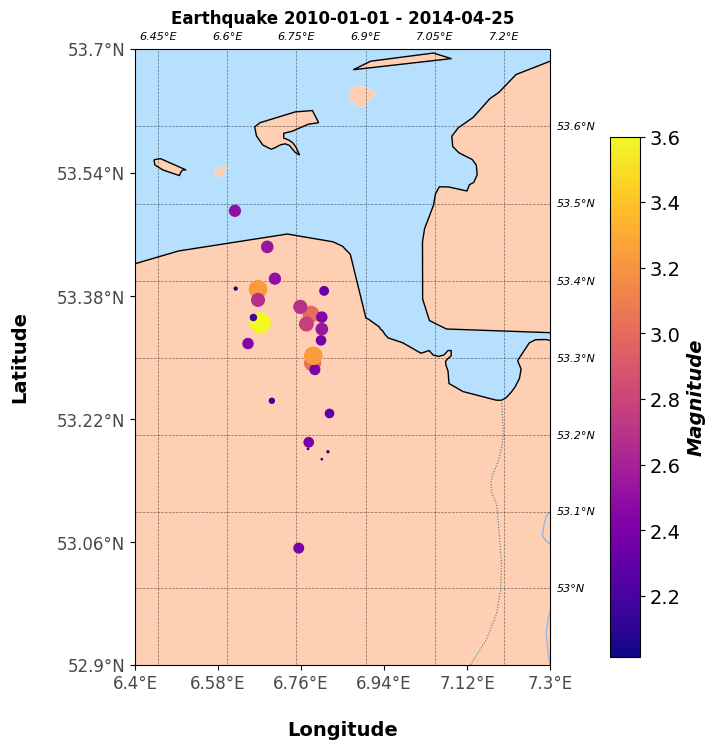

In [4]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

t1 = starttime.strftime('%Y-%m-%d')
t2 = endtime.strftime('%Y-%m-%d')

# assign display resolution
resolution = '10m' 

#longitude 
x = df['Lon'].values
#Latitude
y = df['Lat'].values
# magnitude
z = df['mag'].values

#using mercator projection to display
fig, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.Mercator()}) # ax actually is Geoaxes
ax.set_extent([minlongitude, maxlongitude, minlatitude, maxlatitude],crs=ccrs.PlateCarree())# 

ax.coastlines(resolution='10m',linestyle='-') # add coastline , resolution hace 3 choices 10m,50m or 110m
ax.add_feature(cfeature.BORDERS, # add country border
               linewidth=.75,
               linestyle='dotted',
               edgecolor='#3A6D8C',
               antialiased=True,
)

ax.add_feature(cfeature.LAND.with_scale(resolution), facecolor='#FFCFB3')
ax.add_feature(cfeature.OCEAN.with_scale(resolution), facecolor='#B7E0FF')
ax.add_feature(cfeature.LAKES.with_scale(resolution), facecolor='#4A628A')
ax.add_feature(cfeature.RIVERS.with_scale(resolution), facecolor='#B9E5E8')
# ax.stock_img(name='ne_grey') # add low resolution terrance

# set ticks and adjust label ticks format
x_ticks = np.arange(minlongitude,maxlongitude + maxlongitude/10000, float("{0:.3f}".format(maxlongitude-minlongitude))/5)
y_ticks = np.arange(minlatitude,maxlatitude + maxlatitude/10000, float("{0:.3f}".format(maxlatitude-minlatitude))/5)

ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
## using speclised longitude or latitude Formatter
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.tick_params(axis='both',labelsize=12, labelcolor='#4A4947')


# add parallels or meridians
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=['top','right'],# False meand turn down label from all direction 
                  linewidth=0.5,
                  color='black',
                  alpha=0.5,
                  linestyle='--',
                #   x_inline=True, # label shown in internal of fig
                  )
# manual open or turn off label, if draw_label assigned, the following doesn't necessary
gl.left_labels = False
gl.bottom_labels = False
gl.xlabel_style = {'size': 8, 'color': 'black', 'weight': 'normal', 'fontstyle': 'italic'}  
gl.ylabel_style = {'size': 8, 'color': 'black', 'weight': 'normal', 'fontstyle': 'italic'}

# plot events
norm = Normalize(vmin=z.min(), vmax=z.max())
bubble_size = 200 * norm(z).astype(np.float64) 
scatter = ax.scatter(x, y,c=z, s=bubble_size, cmap='plasma', transform=ccrs.PlateCarree(), zorder=4)

# add colorbar
cax = fig.add_axes([0.78, 0.12,0.03,0.65])
cbar = fig.colorbar(scatter, cax=cax, shrink=0.95, pad=0, orientation='vertical', format="%.1f")
cbar.set_label('Magnitude', size=14, fontdict={'fontstyle':'italic'})

# Add title
title_text = "Earthquake {0} - {1}".format(t1,t2)
ax.set_title(title_text, fontdict={'fontsize':12,'fontweight':'bold'})
ax.set_xlabel('Longitude', labelpad=20)
ax.set_ylabel('Latitude', labelpad=20)



In [5]:
if write_output:
    imagefile = folder_output.joinpath('Magnitude.jpg')
    fig.savefig(imagefile, dpi=240, bbox_inches='tight')